LSTM on past power data to predict power 1, 2 and 3 hours ahead

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import norm

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
x_train = pd.read_csv('windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv('train.csv')
# just consider the wind farm 1

In [ ]:
# Brainstorm
# One metric for 24 hs and other for 48 hs ?
# 0) Check which wind farm to take before working on wf 1
# 0) calculating the MAE for AR-3  -> Baseline RMSE (Confidence interval?)
# 1) Making a prediction based on wp1 using LSTM
# 2) Metric for evaluating the model

In [3]:
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)

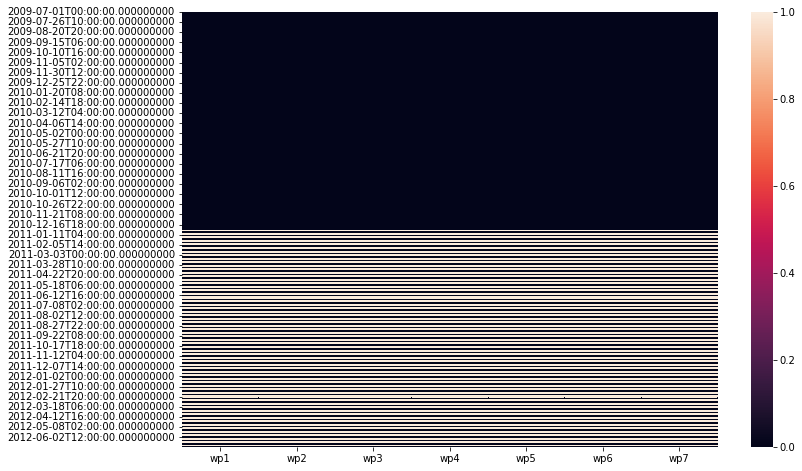

In [4]:
# Plot heatmap of missing data
ALL_TIME =  pd.DataFrame(index=pd.date_range(y_train.index[0],y_train.index[-1], freq='H')) 
plt.figure(figsize = (12,8))
sns.heatmap(y_train.join(ALL_TIME, how = 'outer').isna())  #['2011-06-01':'2011-06-04']

In [ ]:
#y_train.join(ALL_TIME, how = 'outer')
ALL_TIME

In [20]:
# Use only the power time series when continuous

complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
input_generator = np.transpose(np.array([complete_ts.wp1]))
length = 24 # length of the time series, PARAMETER TO TUNE

In [25]:
# define validation and training set

batch_size = 8
# input_generator = np.transpose(np.array([y_train.wp1]))
training_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = 0 , end_index = int(len(complete_ts)*0.8)) # 80 percent
validation_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = int(len(complete_ts)*0.8)+1, end_index = int(len(complete_ts)-1))

In [17]:
print(f'The lenght of the validation set: {len(validation_set)}')
print(f'The lenght of the training set: {len(training_set)}')

The lenght of the validation set: 327
The lenght of the training set: 1315


**Creation of LSTM architecture**

In [79]:
class MyRecurrentNet(nn.Module):
    def __init__(self):
        super(MyRecurrentNet, self).__init__()
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch_first = False >>> input prov (seq, batch, feature)
        self.lstm = nn.LSTM(input_size = 1, 
                  hidden_size = 48,
                     num_layers = 1,
                         batch_first = False)
        
        self.l_out = nn.Linear(in_features= 48,
                               out_features= 1,
                               bias = False) # should be false ?
        
    def forward(self,x):
        #print(np.shape(x))
        x = torch.permute(x, (1,0,2) )
        #print(np.shape(x))
        x, (h, c) = self.lstm(x)
        #print(f'x after lstm: {np.shape(x[-1])}')
        #print(f'h after lstm: {np.shape(h)}')
        # Flatten output for feed-forward layer
        # x = x.view(-1, self.lstm.hidden_size)
        
        # Output layer
        x = self.l_out(x[-1])
        
        return x
  
net = MyRecurrentNet()
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)



##converting network to cuda-enabled
MyRecurrentNet(
  (lstm): LSTM(1, 48)
  (l_out): Linear(in_features=48, out_features=1, bias=False)
)


**Training of the LSTM**

In [80]:
# Train loop 
criterion = nn.MSELoss() 
optimizer = optim.SGD(net.parameters(), lr=0.02) # , momentum=0.9

training_loss, validation_loss = [], []  # store loss for each epoch

num_epochs = 30 # should be tuned
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0

    net.eval() # EVALUATION mode -> dont use regularization methods
        
    # For each sentence in validation set
    for inputs, targets in validation_set:

        # Convert input to tensor
        inputs = torch.Tensor(inputs)
        # print('Inside training loop')
        # print(f'shape of input {np.shape(inputs)}')

        # Convert target to tensor
        targets = torch.Tensor(targets)
        #print(targets)
        # print(f'shape of targets {np.shape(targets)}')
        
        #Convert targets and inputs to cuda
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
        
        # Evaluate the model
        outputs = net(inputs) 

        # print(f'shape of outputs {np.shape(outputs)}')
        #print(outputs)
        # Compute loss
        loss = torch.sqrt( criterion(outputs,targets) )

        if torch.cuda.is_available():
          epoch_validation_loss += loss.cpu().detach().numpy()
        else:
          epoch_validation_loss += loss.detach().numpy()

    
    net.train()

    for inputs, targets in training_set:

        # Convert input to tensor
        inputs = torch.Tensor(inputs)
        # print('Inside training loop')
        # print(f'shape of input {np.shape(inputs)}')

        # Convert target to tensor
        targets = torch.Tensor(targets)
        #print(targets)
        # print(f'shape of targets {np.shape(targets)}')
        
        #Convert targets and inputs to cuda
        if torch.cuda.is_available():
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
        
        # Evaluate the model
        outputs = net(inputs)      
        # print(f'shape of outputs {np.shape(outputs)}')
        #print(outputs)
        # Compute loss
        loss = torch.sqrt( criterion(outputs,targets))

        optimizer.zero_grad() # zero the gradients
        loss.backward()       # calculate gradients for current step
        optimizer.step()      # update the weights 

        if torch.cuda.is_available():
          epoch_training_loss += loss.cpu().detach().numpy()
        else:
          epoch_training_loss += loss.detach().numpy()

     # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))       

    print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')


Epoch 0, training loss: 0.12025869540115924, validation loss: 0.2740954691601137
Epoch 1, training loss: 0.08080353509978225, validation loss: 0.09468417729191277
Epoch 2, training loss: 0.0730007030702034, validation loss: 0.08224750982329751
Epoch 3, training loss: 0.06798210536650322, validation loss: 0.07619268041593948
Epoch 4, training loss: 0.06479380379976286, validation loss: 0.07301437990335514
Epoch 5, training loss: 0.06312474452832027, validation loss: 0.07164560512437368
Epoch 6, training loss: 0.062219267753360105, validation loss: 0.07077004796959209
Epoch 7, training loss: 0.061545840315627, validation loss: 0.06982747131292152
Epoch 8, training loss: 0.060982203011015014, validation loss: 0.06890255342656319
Epoch 9, training loss: 0.06050490629111201, validation loss: 0.06807640136792026
Epoch 10, training loss: 0.0600997556238205, validation loss: 0.06736191745494302
Epoch 11, training loss: 0.05975497476361513, validation loss: 0.06674862667827067
Epoch 12, trainin

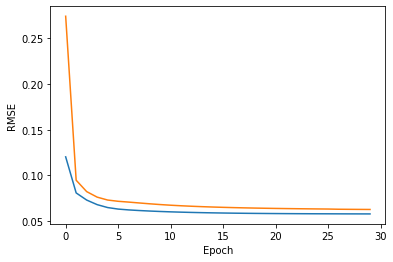

In [81]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, epoch, validation_loss)
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

**Evaluation of LSTM 1, 2 and 3 hours ahead, on validation set**

In [82]:
# Define the validation set as one sequence
validation_power = input_generator[int(len(input_generator)*0.8)+1 : int(len(input_generator))-1]

In [83]:
# Define slices of 24h inputs and corresponding targets 1, 2 and 3 hours ahead
p_inputs = []
p_targets1h = []
p_targets2h = []
p_targets3h = []
for i in range(len(validation_power)-26):
  p_inputs.append(validation_power[i:i+24])
  p_targets1h.append(validation_power[i+24])
  p_targets2h.append(validation_power[i+25])
  p_targets3h.append(validation_power[i+26])

In [84]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []

# Loop over the sequences of valid data
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    
    # Take output for the past sequence
    pred_1h.append(net(torch.Tensor([past])).item())
    err_1h.append(pred_1h[-1]-p_targets1h[seq][0])

    # Repeat with prediction 2 hours ahead actualizing the past values
    past = np.append(past,[[pred_1h[-1]]],0)
    pred_2h.append(net(torch.Tensor([past])).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past = np.append(past,[[pred_2h[-1]]],0)
    pred_3h.append(net(torch.Tensor([past])).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}')

step 1, RMSE 1h: 0.014034885764122013, RMSE 2h: 0.10379092192649841, RMSE 3h: 0.1743603596687317
step 101, RMSE 1h: 0.05451491883172758, RMSE 2h: 0.0890573491333476, RMSE 3h: 0.10731948940756746
step 201, RMSE 1h: 0.06985391903322598, RMSE 2h: 0.11250027841054827, RMSE 3h: 0.13868620975729581
step 301, RMSE 1h: 0.07528228904382482, RMSE 2h: 0.12154334176803384, RMSE 3h: 0.15291210519201395
step 401, RMSE 1h: 0.07086510176597052, RMSE 2h: 0.11365426664940272, RMSE 3h: 0.14296518865539254
step 501, RMSE 1h: 0.06823339496141183, RMSE 2h: 0.10889373574950731, RMSE 3h: 0.1353103623288778
step 601, RMSE 1h: 0.07306117089033802, RMSE 2h: 0.11467685393737259, RMSE 3h: 0.14130815685855153
step 701, RMSE 1h: 0.06967794320414555, RMSE 2h: 0.10975801349747218, RMSE 3h: 0.13544646543948197
step 801, RMSE 1h: 0.07076759832576048, RMSE 2h: 0.11276178333360443, RMSE 3h: 0.13929222668564264
step 901, RMSE 1h: 0.07309767440333155, RMSE 2h: 0.1176211567390674, RMSE 3h: 0.146530864359192
step 1001, RMSE 1

In [87]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')

Confidence interval 1h: [-0.1399672242899775, 0.13996722428997746]
Confidence interval 2h: [-0.2265869645200407, 0.22658696452004065]
Confidence interval 3h: [-0.28862030252151655, 0.2886203025215165]
